In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

# !ls

In [2]:
import os

home_dir = '/content/gdrive/My Drive/ATFTransformer'
home_dir = '/hy-tmp'
os.chdir(home_dir)
!pwd

!pip install tqdm
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import multiprocessing
import time

from multiprocessing import Pool, freeze_support

/hy-tmp
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [3]:
data_dir = os.path.join(home_dir)
os.chdir(data_dir)
!pwd
# !ls

files = glob(os.path.join(data_dir, '*.npz'))

print(files)

/hy-tmp
['/hy-tmp/corn_histogram_all_full.npz']


In [4]:
filename = '/hy-tmp/corn_histogram_all_full.npz'

hists = np.load(filename)

print(type(hists), list(hists.keys()))
print(type(hists['output_image']), hists['output_image'].shape)

<class 'numpy.lib.npyio.NpzFile'> ['output_image', 'output_yield', 'output_year', 'output_locations', 'output_index', 'output_sownareas', 'output_yieldvals']
<class 'numpy.ndarray'> (320, 9, 32, 512)


In [ ]:
freeze_support()

print(type(hists['output_image']), hists['output_image'].shape)

bins_name = list()
bins_valu = list()

for band in range(0, hists['output_image'].shape[1]):
    for bins in range(0, hists['output_image'].shape[3]):
        bins_name.append(f'band_{band}_{bins}')

# print(bins_name)
print(hists['output_image'][0][0][0].shape)
# print(list(hists['output_image'][0][0][0]))
print(hists['output_index'][100][1])

# fn

idx_s = [x for x in range(0,319,29)]
idx_e = [x for x in range(29,320,29)]

print(len(idx_s), idx_s)
print(len(idx_e), idx_e)

# idx_s = [x for x in range(0,320,40)]
# idx_e = [x for x in range(40,321,40)]

# print(len(idx_s), idx_s)
# print(len(idx_e), idx_e)

# fn

def get_ds(idx_s, idx_e):
    hists = np.load('/hy-tmp/corn_histogram_all_full.npz')
    df = pd.DataFrame()

    time_idx = 0
    index_idx = 0
    for idx in range(idx_s, idx_e):
        for time_idx in range(0, hists['output_image'].shape[2]):
            bins_dict = dict()
            for band_idx in range(0, hists['output_image'].shape[1]):    
                bins_name = list()
                for bins in range(0, hists['output_image'].shape[3]):
                    bins_name.append(f'band_{band_idx}_{bins}')
                bins_dict.update(dict(zip(bins_name,list(hists['output_image'][idx][band_idx][time_idx]))))
            # print(len(bins_dict), bins_dict)
            # fn

            df1 = pd.DataFrame( hists['output_year'][idx], columns=['years'], index=[index_idx] )
            df2 = pd.DataFrame( hists['output_yield'][idx], columns=['yield'], index=[index_idx] )
            df3 = pd.DataFrame( hists['output_sownareas'][idx], columns=['sownareas'], index=[index_idx] )
            df4 = pd.DataFrame( hists['output_yieldvals'][idx], columns=['yieldvals'], index=[index_idx] )
            df5 = pd.DataFrame( hists['output_index'][idx][1], columns=['county'], index=[index_idx] )
            df6 = pd.DataFrame( f'MOD_{time_idx}', columns=['MODIS'], index=[index_idx] )
            df7 = pd.DataFrame( time_idx, columns=['time_idx'], index=[index_idx] )
            df8 = pd.DataFrame(bins_dict, index=[index_idx])

            df_r = pd.concat( [df1 , df2], axis=1)
            df_r = pd.concat( [df_r, df3], axis=1)
            df_r = pd.concat( [df_r, df4], axis=1)
            df_r = pd.concat( [df_r, df5], axis=1)
            df_r = pd.concat( [df_r, df6], axis=1)
            df_r = pd.concat( [df_r, df7], axis=1)
            df_r = pd.concat( [df_r, df8], axis=1)

            df = pd.concat( [df, df_r], axis=0)

            index_idx = index_idx + 1
            
    return df

with Pool(processes=11) as pool:
    results = pool.starmap(get_ds, zip(idx_s, idx_e))

# df.to_csv('china_prl.csv')


# fn
# for indx in range(0, hists.shape[0]):
#   for time_idx in range(0, hists.shape[2]):
#     for bands in range(0, hists.shape[1]):


<class 'numpy.ndarray'> (320, 9, 32, 512)
(512,)
9
11 [0, 29, 58, 87, 116, 145, 174, 203, 232, 261, 290]
11 [29, 58, 87, 116, 145, 174, 203, 232, 261, 290, 319]


In [ ]:
print(type(results), len(results))

filesave = 'corn_china_pandas_onebands.csv'

df = pd.DataFrame()
for ii in range(0, 11):
    df = pd.concat( [df, results[ii]], axis=0 )
    
df.head()
    
df.to_csv(filesave)
    

In [10]:
ds = pd.read_csv(filesave)
ds[8340:8390]

,Unnamed: 0,years,yield,sownareas,yieldvals,county,MODIS,time_idx,band_0_0,band_0_1,...,band_8_502,band_8_503,band_8_504,band_8_505,band_8_506,band_8_507,band_8_508,band_8_509,band_8_510,band_8_511
8340,916,2007,0.453846,756.60,343.38,23,MOD_20,20,0.000196,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8341,917,2007,0.453846,756.60,343.38,23,MOD_21,21,0.000061,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8342,918,2007,0.453846,756.60,343.38,23,MOD_22,22,0.000181,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8343,919,2007,0.453846,756.60,343.38,23,MOD_23,23,0.000593,0.000105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8344,920,2007,0.453846,756.60,343.38,23,MOD_24,24,0.000070,0.000035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8345,921,2007,0.453846,756.60,343.38,23,MOD_25,25,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8346,922,2007,0.453846,756.60,343.38,23,MOD_26,26,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8347,923,2007,0.453846,756.60,343.38,23,MOD_27,27,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8348,924,2007,0.453846,756.60,343.38,23,MOD_28,28,0.000063,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8349,925,2007,0.453846,756.60,343.38,23,MOD_29,29,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# ds

# print((ds[f'band_{0}_{0}'].iloc[256]))
# fn

indx = 0
spec = list()
for band in tqdm(range(0, 9)):
    for bins in range(0, 512):
        # print(len(ds[f'band_{band}_{bins}'])
        spec.append( ds[f'band_{band}_{bins}'].iloc[indx] )

Y = np.asarray(spec)

100%|██████████| 9/9 [00:00<00:00, 134.58it/s]


In [25]:
print(type(Y[250]))

<class 'numpy.float64'>


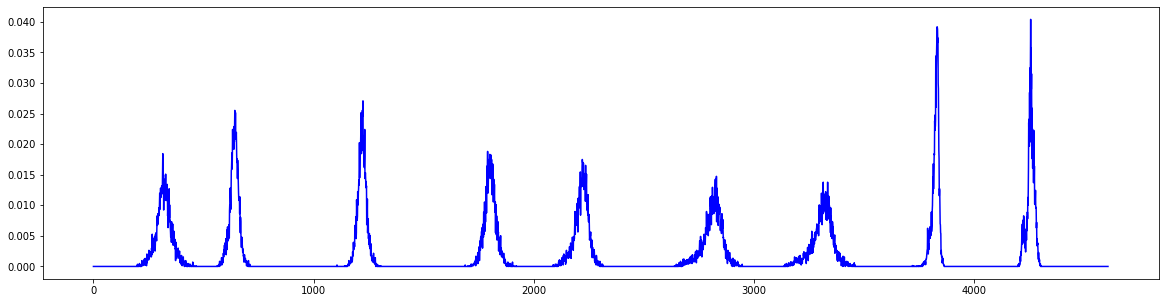

In [26]:
from matplotlib import pyplot as plt

X = [X for X in range(0, Y.shape[0])]

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20,5))

ax1.plot(X, Y, color='b', label="Actual")
# ax1.plot(X, predictions, color='r', label="Predicted")

In [ ]:
# !zip corn_china_pandas_prl11.csv.zip corn_china_pandas.csv
!cp corn_china_pandas_onebands.csv corn_china_pandas_onebands.csv.zip
!oss cp corn_china_pandas_onebands.csv.zip oss://

In [ ]:
os.system("shutdown /s /t 1")

In [ ]:
print(type(hists['output_image']), hists['output_image'].shape)
print(type(hists['output_yield']), hists['output_yield'].shape)
print(type(hists['output_year']), hists['output_year'].shape)
print(type(hists['output_locations']), hists['output_locations'].shape)
print(type(hists['output_index']), hists['output_index'].shape)
print(hists['output_year'])
# print(hists['output_index'])
# fn

In [ ]:
from matplotlib import pyplot as plt
# print(hists['output_index'])

bands = [x for x in range(0,9,1)]
years = [x for x in range(2003, 2019, 1)]
times = [x for x in range(0,32,1)]

print('years :', years)
      
counties = [0, 1, 2, 3, 5, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 24, 26, 29]

num_bins = 512
bin_seq = np.linspace(1, num_bins, num_bins + 1) 

# fig, axs = plt.subplots(1, 9, figsize=(25,5))

it = 0
for county in range(0,len(counties),1):
  fig, axs = plt.subplots(1, 9, figsize=(25,5))
  for year in [0,1]:  #range(0,len(years),1): 
    for band in bands:
      for time in times:
        density = hists['output_image'][it,band,time,:]
        # print(len(density))
        axs[band].plot(bin_seq[0:-1], density)
      it = it + 1
    print(it)

  plt.show()
  